# Unbalanced Cell Type Alignment

```{note}
This notebook is a sample of what our applications chapter will look like when we fully release it. We're working hard on compiling all of our results to share with you!
```

In this notebook, we'll look at what happens when we systematically downsample one of our domains in an alignment problem (simulating a situtation where we only have separately assayed data). In particular, we'll systematically downsample by cell type in a PBMC co-assayed dataset that contains RNA-seq (gene expression) and ATAC-seq (open chromatin) data. For now, we have provided our preprocessed version of this dataset in smaller files in the GitHub repository of this book, although we plan on additionally sharing our preprocessing steps once we have them in a publishable format.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, fused formulation tutorials. We will draw on all of these when examining AGW.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you want to understand how to use AGW more generally, visit our AGW tutorial.
```

### Preprocessing

We can begin by loading in our data:

In [1]:
import pickle
import scanpy as sc
rna = pickle.load(open('./data/PBMC/rna_50pca_50topics.pkl', 'rb'))
atac = pickle.load(open('./data/PBMC/atac_50pca_50topics.pkl', 'rb'))
adata = sc.read_h5ad('./data/PBMC/adata.h5ad')

In [2]:
rna.shape

(2407, 50)

We can name our data and look at its shape:

In [35]:
import pandas as pd
atac.columns = ["Region {0}".format(i + 1) for i in range(50)]
rna.columns = ["Gene {0}".format(i + 1) for i in range(50)]
rna.shape, atac.shape

((2407, 50), (2407, 50))

We can additionally look at the cell types present:

In [36]:
ctypes = adata.obs['celltype']
ctypes = pd.Series(ctypes).loc[atac.index]
ctypes

CCAAGTTAGTAACCAC-1      CD14+ Monocytes
GTGCTTACAGTAATAG-1      CD14+ Monocytes
AGTCTTGCACAAAGAC-1    FCGR3A+ Monocytes
CTTTATGGTAAGCACC-1          CD4 T cells
CAATCGCCACTTCACT-1          CD4 T cells
                            ...        
CCGGTAGGTCGTTACT-1          CD4 T cells
CTAAATGTCTATTGTC-1          CD4 T cells
CCGCACACACTTCACT-1      CD14+ Monocytes
AATGCAACACCACAAC-1          CD4 T cells
CAAGGTTTCCCTGACT-1          CD4 T cells
Name: celltype, Length: 2407, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [37]:
# attach celltype info to rna/atac data
rna = pd.concat((rna, ctypes), axis=1)
atac = pd.concat((atac, ctypes), axis=1)

In [38]:
from collections import Counter
Counter(rna['celltype']),Counter(atac['celltype'])

(Counter({'CD4 T cells': 1114,
          'CD14+ Monocytes': 648,
          'CD8 T cells': 207,
          'B cells': 201,
          'FCGR3A+ Monocytes': 109,
          'NK cells': 84,
          'Dendritic cells': 44}),
 Counter({'CD4 T cells': 1114,
          'CD14+ Monocytes': 648,
          'CD8 T cells': 207,
          'B cells': 201,
          'FCGR3A+ Monocytes': 109,
          'NK cells': 84,
          'Dendritic cells': 44}))

From here, we can randomly sample fractions of each cell type to keep in the both domains:

In [39]:
import random

random.seed(5)
atac_dfs = []
rna_dfs = []
atac_fracs = {}
rna_fracs = {}
for ctype, df in atac.groupby("celltype", observed=True):
    print(ctype)
    atac_fracs[df["celltype"].iloc[0]] = 0.5 + 0.05*random.choice(range(0, 11, 1))
    atac_dfs.append(df.sample(frac=atac_fracs[df["celltype"].iloc[0]], random_state=10))
for ctype, df in rna.groupby("celltype", observed=True):
    print(ctype)
    rna_fracs[df["celltype"].iloc[0]] = 0.5 + 0.05*random.choice(range(0, 11, 1))
    rna_dfs.append(df.sample(frac=rna_fracs[df["celltype"].iloc[0]], random_state=10))
atac_mod = pd.concat((atac_dfs), axis=0)
rna_mod = pd.concat((rna_dfs), axis=0)

B cells
CD4 T cells
CD8 T cells
CD14+ Monocytes
Dendritic cells
FCGR3A+ Monocytes
NK cells
B cells
CD4 T cells
CD8 T cells
CD14+ Monocytes
Dendritic cells
FCGR3A+ Monocytes
NK cells


In [68]:
# retrieving numeric matrices
atac_mtx_full = atac.iloc[:, :-1]
atac_mtx = atac_mod.iloc[:, :-1]
rna_mtx_full = rna.iloc[:, :-1]
rna_mtx = rna_mod.iloc[:, :-1]

Note that we can easily view the manner in which we downsampled our data:

In [41]:
rna_fracs

{'B cells': 0.65,
 'CD4 T cells': 1.0,
 'CD8 T cells': 0.5,
 'CD14+ Monocytes': 0.6,
 'Dendritic cells': 0.55,
 'FCGR3A+ Monocytes': 0.75,
 'NK cells': 0.8500000000000001}

In [42]:
atac_fracs

{'B cells': 0.95,
 'CD4 T cells': 0.7,
 'CD8 T cells': 0.75,
 'CD14+ Monocytes': 1.0,
 'Dendritic cells': 0.9,
 'FCGR3A+ Monocytes': 0.5,
 'NK cells': 0.8500000000000001}

### Alignment Setup

Now, we can begin our usual SCOT+ workflow:

In [43]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

As usual, we normalize our data:

In [69]:
rna_mtx=normalize(rna_mtx)
atac_mtx=normalize(atac_mtx)
atac_mtx_full=normalize(atac_mtx_full)
rna_mtx_full=normalize(rna_mtx_full)

And visualize it in two dimensions before alignment:

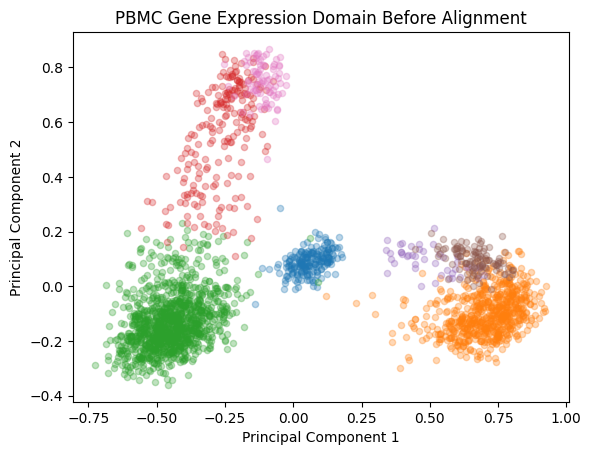

In [45]:
# visualize rna
import numpy as np

label_array = np.array(rna['celltype'].to_list())

unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx_full)
rna_2Dpca = rna_pca.transform(rna_mtx_full)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

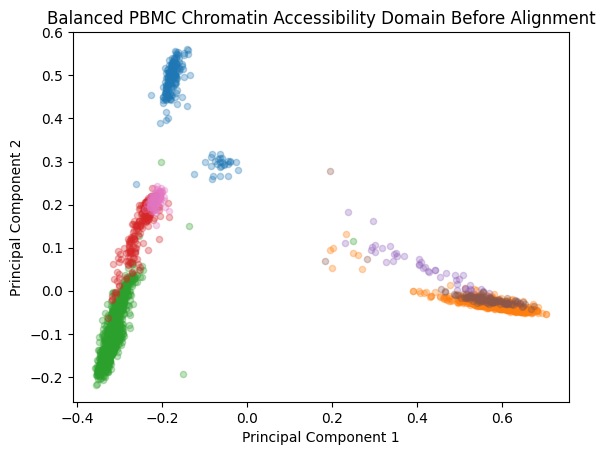

In [46]:
# visualize ATAC
import numpy as np

label_array = np.array(atac['celltype'].to_list())

unique_labels = np.unique(label_array)
atac_pca=PCA(n_components=2)
atac_2Dpca=atac_pca.fit_transform(atac_mtx_full)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(atac_2Dpca[subset, 0], atac_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Balanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

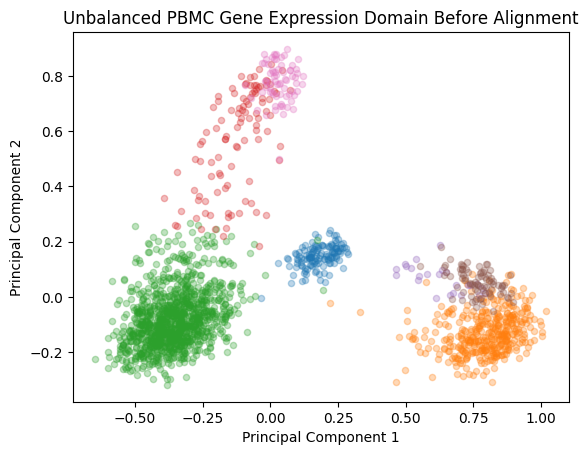

In [47]:
# visualize subsetted rna
import numpy as np

label_array = np.array(rna_mod['celltype'].to_list())

unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=20, alpha=0.3,label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

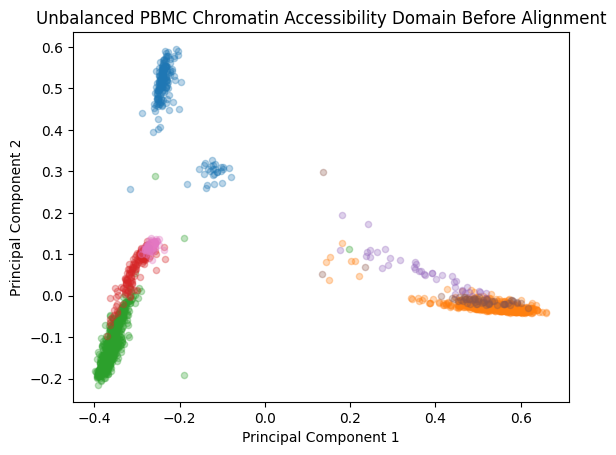

In [48]:
# visualize subsetted ATAC
import numpy as np

label_array = np.array(atac_mod['celltype'].to_list())

unique_labels = np.unique(label_array)
atac_pca=PCA(n_components=2)
atac_2Dpca=atac_pca.fit_transform(atac_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(atac_2Dpca[subset, 0], atac_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Balanced

We can start by looking at the balanced alignment with GW:

In [49]:
# compute distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_rna = compute_graph_distances(rna_mtx_full, n_neighbors=100, mode='connectivity')
D_atac = compute_graph_distances(atac_mtx_full.astype('float32'), n_neighbors=100, mode='connectivity')

In [51]:
from scotplus.utils.alignment import get_barycentre, FOSCTTM

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=15)

# original grid search
# scores = pd.Series(index=[x for x in np.logspace(-3, -1, 20)], name="FOSCTTM")
# for eps in reversed([x for x in np.logspace(-3, -1, 20)]):
#     print(eps)
#     pi_samp,_,pi_feat = scot.gw(D_rna, D_atac, eps = eps, verbose = False)
#     aligned_atac = get_barycentre(rna_mtx_full, np.transpose(pi_samp))
#     scores.loc[eps] = np.mean(FOSCTTM(rna_mtx_full, aligned_atac.numpy()))
pi_samp,_,pi_feat = scot.gw(D_rna, D_atac, eps = 0.002, verbose = False)
aligned_atac = get_barycentre(rna_mtx_full, np.transpose(pi_samp))
np.mean(FOSCTTM(rna_mtx_full, aligned_atac.numpy()))

0.12253779068462342

We can quickly get a sense for an upper threshold for performance we might expect in the unbalanced case by looking at the FOSCTTM.

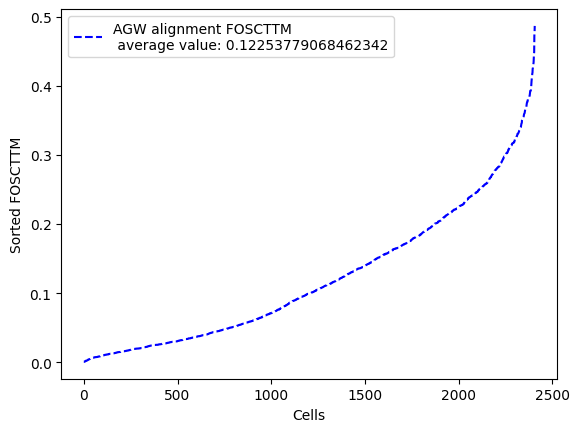

In [52]:
from scotplus.utils.alignment import FOSCTTM
fracs = FOSCTTM(rna_mtx_full, aligned_atac.numpy())
legend_label="AGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

In [53]:
import pickle
pickle.dump(pd.concat((pd.DataFrame(rna_mtx_full), rna["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/balanced_orig_rna_pbmc_fig.pkl", mode='wb'))
pickle.dump(pd.concat((pd.DataFrame(atac_mtx_full), rna["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/balanced_orig_atac_pbmc_fig.pkl", mode='wb'))
pickle.dump(pd.concat((pd.DataFrame(aligned_atac), rna["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/balanced_aligned_atac_pbmc_fig.pkl", mode='wb'))


### Balanced Evaluation

In [92]:
rna_mtx_full = pickle.load(open("data/PBMC/balanced_orig_rna_pbmc_fig.pkl", 'rb')).iloc[:, :50]
atac_mtx_full = pickle.load(open("data/PBMC/balanced_orig_atac_pbmc_fig.pkl", 'rb')).iloc[:, :50]
aligned_atac = pickle.load(open("data/PBMC/balanced_aligned_atac_pbmc_fig.pkl", 'rb')).iloc[:, :50]

rna_mtx_full.shape, atac_mtx_full.shape, aligned_atac.shape

((2407, 50), (2407, 50), (2407, 50))

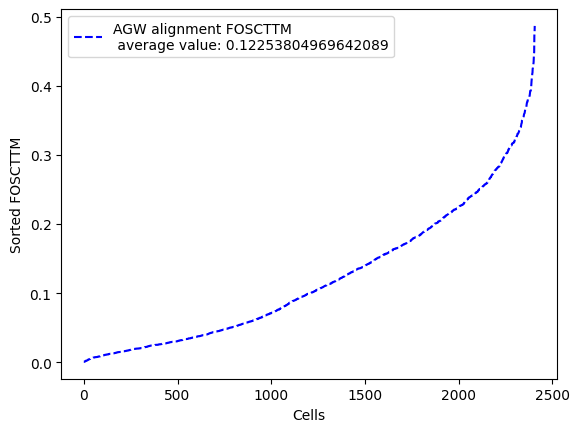

In [94]:
from scotplus.utils.alignment import FOSCTTM
fracs = FOSCTTM(rna_mtx_full, aligned_atac)
legend_label="AGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

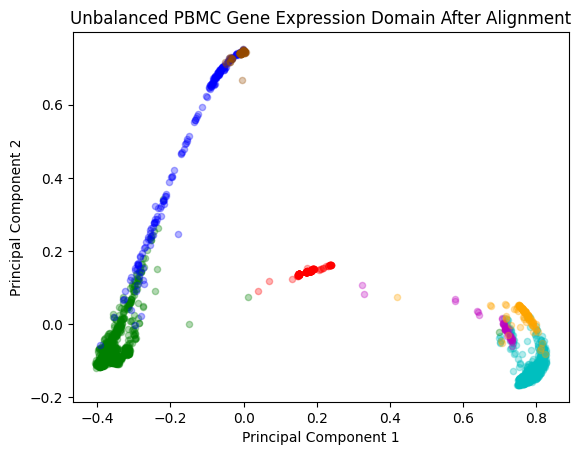

In [71]:
Xrna_integrated=rna_mtx_full
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(atac['celltype'])
for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (x_labels == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20, alpha=0.3, label = label, c=color)
    
    
plt.title('Balanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


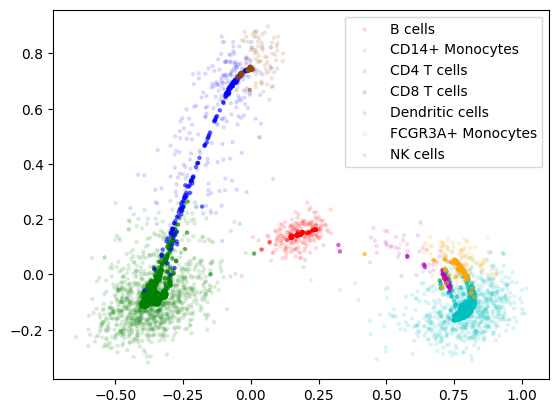

In [72]:
Xrna_integrated=rna_mtx_full
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

rna_labels = np.array(rna['celltype'])
atac_labels = np.array(atac['celltype'])
alphas = (np.hstack((np.ones_like(rna_labels, dtype=int)/10, np.ones_like(atac_labels, dtype=int)/2)))

for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (np.hstack((rna_labels, atac_labels)) == label)
    plt.scatter(np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 0], np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()


We can now attempt an unbalanced alignment:

In [73]:
# compute new distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_urna = compute_graph_distances(rna_mtx.astype('float32'), n_neighbors=100, mode='connectivity')
D_uatac = compute_graph_distances(atac_mtx.astype('float32'), n_neighbors=100, mode='connectivity')

In [74]:
from scotplus.utils.alignment import get_barycentre, LTA

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=15)

# scores = pd.Series(name="LTA")
# for rho in [0.01, 0.1, 1, float('inf')]:
#     for eps in reversed([x for x in np.logspace(-3, -1, 20)]):
#         print(eps,rho)
#         pi_samp,_,pi_feat = scot.ugw(D_urna, D_uatac, eps = eps, rho=rho, verbose = False)
#         aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
#         scores.loc[(rho,eps)] = LTA(rna_mtx, aligned_atac, rna_mod["celltypes"], atac_mod["celltypes"], k=5)
pi_samp,_,pi_feat = scot.ugw(D_urna, D_uatac, eps = 0.00127, rho=0.01, verbose = False)
aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
LTA(rna_mtx, aligned_atac, rna_mod["celltype"], atac_mod["celltype"], k=10)

0.9263707571801567

In [75]:
len(rna_mtx)

1915

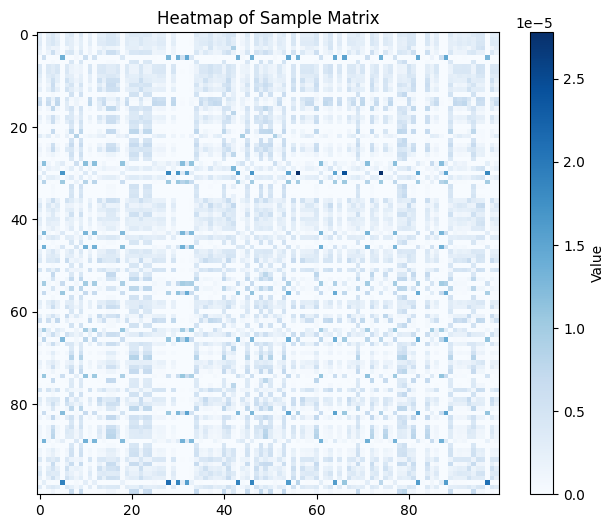

In [76]:
# plot a corner of the heatmap to get a sense for density
plt.figure(figsize=(8, 6))
plt.imshow(pi_samp[0:100,0:100], cmap='Blues', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of Sample Matrix')
plt.show()

Now, we can finally compute our alignment:

In [77]:
from scotplus.utils.alignment import get_barycentre
aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
rna_mtx.shape, atac_mtx.shape, aligned_atac.shape

((1915, 50), (1939, 50), torch.Size([1939, 50]))

In [78]:
import pickle
pickle.dump(pd.concat((pd.DataFrame(rna_mtx), rna_mod["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/unbalanced_orig_rna_pbmc_fig.pkl", mode='wb'))
pickle.dump(pd.concat((pd.DataFrame(atac_mtx), atac_mod["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/unbalanced_orig_atac_pbmc_fig.pkl", mode='wb'))
pickle.dump(pd.concat((pd.DataFrame(aligned_atac), atac_mod["celltype"].reset_index()), axis=1).set_index("index"), open(r"data/PBMC/unbalanced_aligned_atac_pbmc_fig.pkl", mode='wb'))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

In [97]:
rna_mtx = pickle.load(open("data/PBMC/unbalanced_orig_rna_pbmc_fig.pkl", 'rb')).iloc[:, :50]
atac_mtx = pickle.load(open("data/PBMC/unbalanced_orig_atac_pbmc_fig.pkl", 'rb')).iloc[:, :50]
aligned_atac = pickle.load(open("data/PBMC/unbalanced_aligned_atac_pbmc_fig.pkl", 'rb')).iloc[:, :50]

rna_mtx.shape, atac_mtx.shape, aligned_atac.shape

((1915, 50), (1939, 50), (1939, 50))

In [95]:
set(rna_mod['celltype'].values).union(atac_mod['celltype'].values)

{'B cells',
 'CD14+ Monocytes',
 'CD4 T cells',
 'CD8 T cells',
 'Dendritic cells',
 'FCGR3A+ Monocytes',
 'NK cells'}

In [98]:
LTA(rna_mtx, aligned_atac, rna_mod['celltype'], atac_mod['celltype'], k=7)

0.9253263707571802

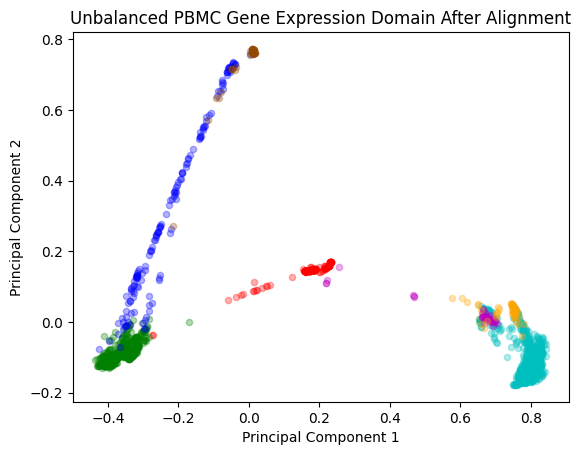

In [86]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

atac_labels = np.array(atac_mod['celltype'])

for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (atac_labels == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20, alpha=0.3, label = label, c=color)
    
    
plt.title('Unbalanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


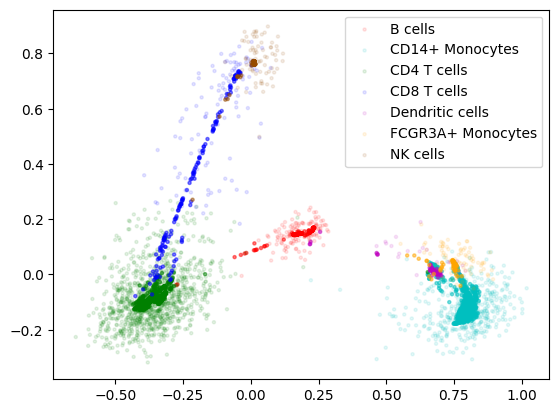

In [87]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

rna_labels = np.array(rna_mod['celltype'])
atac_labels = np.array(atac_mod['celltype'])
alphas = (np.hstack((np.ones_like(rna_labels, dtype=int)/10, np.ones_like(atac_labels, dtype=int)/2)))

for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (np.hstack((rna_labels, atac_labels)) == label)
    plt.scatter(np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 0], np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()
